In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import signal, ndimage, interpolate, stats
from scipy.interpolate import CubicSpline
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredText
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

import seaborn as sns
font = {'family' : 'sans-serif',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('text',usetex=False)

from pathlib import Path
import os,sys
import h5py, json
import sys 
import pickle as pkl
import time

import nept
sys.path.append('../PreProcessing/')  
sys.path.append('../TrackingAnalyses/')  
sys.path.append('../Lib/')
sys.path.append('../Analyses/')
from filters_ag import *

from importlib import reload  # Python 3.4+ only.
import pre_process_neuralynx as PPN
import TreeMazeFunctions as TMF
import spike_functions as SF
import spatial_tuning as ST
import stats_functions as StatsF
import plot_functions as PF
import zone_analyses_session as ZA


In [2]:
oakPaths = {}
oakPaths['Root'] = Path('/mnt/o/giocomo/alexg/')
oakPaths['Clustered'] = oakPaths['Root']/'Clustered'
oakPaths['PreProcessed'] = oakPaths['Root']/'PreProcessed'
oakPaths['Raw'] =oakPaths['Root'] / 'RawData'/'InVivo'
oakPaths['Analyses'] =oakPaths['Root']/'Analyses'

In [3]:
animal = 'Li'
task = 'T3g'
date = '062718'
session = animal+'_'+task+'_'+date

In [5]:
sessionPaths = ZA.getSessionPaths(oakPaths,session)
PosDat = TMF.getBehTrackData(sessionPaths,0)
cell_bin_spikes, mua_bin_spikes, ids= SF.getSessionBinSpikes(sessionPaths,PosDat['t'])
cell_FR, mua_FR = SF.getSessionFR(sessionPaths)
mu=np.mean(cell_FR,1)
sig=np.std(cell_FR,1)

Loading Beh Tracking Data
Complete.
Loading Spikes...
Binned Spike Files Loaded.
Loading FRs ...
FR Loaded.


In [624]:
def getPosSequence(PosZones,startID,endID):
    nSamps = len(PosZones)
    pos = []
    samp = []
    
    pos.append(PosZones[0])
    samp.append(0)
    for p in np.arange(nSamps-1):
        p0 = PosZones[p]
        p1 = PosZones[p+1]
        if p0!=p1:
            pos.append(p1)
            samp.append(p+1)
    pos = np.array(pos)
    samp = np.array(samp) + startID
    nPos = len(pos)
    dur = np.zeros(nPos,dtype=int)
    for p in np.arange(nPos-1):
        dur[p] = samp[p+1]-samp[p]
    dur[-1] = endID-samp[-1]
        
    return pos, samp, dur

def cmp(a,b):
    return (a>b)-(a<b)

def getTrials(dat,**kwargs):
    nTr = dat.shape[0]
    trials = set(np.arange(nTr))
    try:
        for k,v in kwargs.items():
            trials = trials & set(np.where(dat[k]==v)[0])
    except:
        print('Invalid Selection {} {}'.format(k,v))
        pass
    return np.sort(np.array(list(trials)))

def zMat(mat,mu,sig):
    return (mat-mu)/sig

def getFR_TrZone(TrialInfo, FRMat):
    nCells = cell_FR.shape[0]
    TrZnFR = {} # FR for every zone visited in that trial
    OTrZnFR = {} # FR for every zone visited in that trial
    
    for tr in TrialInfo['All']['Trials']:
        nPos = len(TrialInfo['TrSeq']['Pos'][tr])
        trSpPos = np.zeros((nCells,nPos))
        for p in np.arange(nPos):
            s=TrialInfo['TrSeq']['Samp'][tr][p]
            d=TrialInfo['TrSeq']['Dur'][tr][p] 
            samps = np.arange(s,s+d)
            for cell in np.arange(nCells):
                trSpPos[cell, p]=np.mean(FRMat[cell][samps])
        
        nPos = len(TrialInfo['OffTrSeq']['Pos'][tr])
        otrSpPos = np.zeros((nCells,nPos))
        for p in np.arange(nPos):
            s=TrialInfo['OffTrSeq']['Samp'][tr][p]
            d=TrialInfo['OffTrSeq']['Dur'][tr][p] 
            samps = np.arange(s,s+d)
            for cell in np.arange(nCells):
                otrSpPos[cell, p]=np.mean(FRMat[cell][samps])
        
        TrZnFR[tr] = trSpPos
        OTrZnFR[tr] = otrSpPos
    return TrZnFR, OTrZnFR

In [7]:
TrialVec = PosDat['EventDat']['TrID']
nTr=TrialVec.max()

startIDs = np.zeros(nTr,dtype=int)
endIDs = np.zeros(nTr,dtype=int)
for tr in np.arange(nTr):
    trIDs = np.where(TrialVec==(tr+1))[0]
    startIDs[tr]=trIDs[0]
    endIDs[tr] = trIDs[-1]

TrialDurs = endIDs-startIDs

OffTrialDurs=np.concatenate((startIDs[1:],[len(PosDat['t'])]))-endIDs
OffTrialVec = np.full_like(TrialVec,0)

for tr in np.arange(nTr):
    idx = np.arange(endIDs[tr],endIDs[tr]+OffTrialDurs[tr])
    OffTrialVec[idx]=tr+1
    

In [385]:
ValidTrSeqs = {'R_S1':['Home','SegA','Center','SegB','I1','SegC','G1'],
               'R_S2':['Home','SegA','Center','SegB','I1','SegD','G2'],
               'L_S3':['Home','SegA','Center','SegE','I2','SegF','G3'],
               'L_S4':['Home','SegA','Center','SegE','I2','SegG','G4'],
               'R_L1':['Home','SegA','Center','SegB','I1','SegD','G2','SegD','I1','SegC','G1'],
               'R_L2':['Home','SegA','Center','SegB','I1','SegC','G1','SegC','I1','SegD','G2'],
               'L_L3':['Home','SegA','Center','SegE','I2','SegG','G4','SegG','I2','SegF','G3'],
               'L_L4':['Home','SegA','Center','SegE','I2','SegF','G3','SegF','I2','SegG','G4'],
              }
ValidOffTrSeqs = {}
for k,v in ValidTrSeqs.items():
    ValidOffTrSeqs[k] = v[::-1]

# Pre allocated Trial Info structure.
TrialInfo = {'All':{'Trials':[],'Co':[],'InCo':[]},'L':{'Trials':[],'Co':[],'InCo':[]},
             'R':{'Trials':[],'Co':[],'InCo':[]},'BadTr':[],'Cues':np.full(nTr,''),'Desc':np.full(nTr,''),
             'DurThr':45,'TrDurs':TrialDurs,
             'TrialVec':TrialVec,'TrStSamp':startIDs,'TrEnSamp':endIDs,'TrSeq':{'Pos':{},'Samp':{},'Dur':{}},
             'OffTrStSamp':endIDs,'OffTrEnSamp':endIDs+OffTrialDurs,'OffTrDurs':OffTrialDurs,
             'OffTrialVec':OffTrialVec, 'OffTrSeq':{'Pos':{},'Samp':{},'Dur':{}},
             'ValidSeqTrials':[],'ValidSeqOffTrials':[],'ValidSeqTrID':[],'ValidSeqOffTrID':[],
             'ValidSeqNames':ValidTrSeqs,'ValidSeqOffNames':ValidOffTrSeqs}

TrialInfo['All']['Trials']=np.arange(nTr)+1
#get separate trials and allocate by correct/incorrect
for tr in TrialInfo['All']['Trials']:
    idx= TrialVec==tr
    for s in ['L','R']:
        c = PosDat['EventDat']['C'+s][idx]        
        d = PosDat['EventDat'][s+'Ds'][idx]
        if np.mean(d)>0.5: # descicion
            TrialInfo['Desc'][tr-1]=s
        if np.mean(c)>0.5: # cue
            TrialInfo[s]['Trials'].append(tr)
            TrialInfo['Cues'][tr-1]=s
            if np.mean(d&c)>0.5: # correct descicion
                TrialInfo[s]['Co'].append(tr)
            else:
                TrialInfo[s]['InCo'].append(tr)
assert set(TrialInfo['R']['Trials']) & set(TrialInfo['L']['Trials']) == set(), 'Trial classified as both left and right.'
assert len(TrialInfo['Cues']) ==len(TrialInfo['Desc']), 'Number of trials mismatch'
assert len(TrialInfo['Cues']) ==nTr, 'Number of trials mismatch'

for trC in ['Co', 'InCo']:
    TrialInfo['All'][trC] = np.sort(TrialInfo['L'][trC]+TrialInfo['R'][trC])

for i in ['All','L','R']:
    for j in ['Trials','Co','InCo']:
        TrialInfo[i]['n'+j]=len(TrialInfo[i][j])
        TrialInfo[i][j]=np.array(TrialInfo[i][j])

# determine if the trials are too long to be included.
TrialInfo['BadTr'] = np.where(TrialInfo['TrDurs']*PosDat['step']>TrialInfo['DurThr'])[0]

# get positions for each trial
for tr in TrialInfo['All']['Trials']:
    
    idx = TrialInfo['TrialVec']==tr
    sID = TrialInfo['TrStSamp'][tr-1]
    eID = TrialInfo['TrEnSamp'][tr-1]
    
    p,s,d=getPosSequence(PosDat['PosZones'][idx],sID,eID)
    #p,s,d=getPosSequence(p4[idx],sID,eID)
    
    TrialInfo['TrSeq']['Pos'][tr]=p
    TrialInfo['TrSeq']['Samp'][tr]=s
    TrialInfo['TrSeq']['Dur'][tr]=d
    
    idx = TrialInfo['OffTrialVec']==tr
    sID = TrialInfo['OffTrStSamp'][tr-1]
    eID = TrialInfo['OffTrEnSamp'][tr-1]
    
    p,s,d=getPosSequence(PosDat['PosZones'][idx],sID,eID)    

    TrialInfo['OffTrSeq']['Pos'][tr]=p
    TrialInfo['OffTrSeq']['Samp'][tr]=s
    TrialInfo['OffTrSeq']['Dur'][tr]=d

# determine if the sequence of positions are valid for each trial
TrSeqs = {}
vTr = []
OffTrSeqs = {}
vOTr = []
for tr in TrialInfo['All']['Trials']:
    seq = [TMF.Zones[a] for a in TrialInfo['TrSeq']['Pos'][tr]]
    match = 0
    for vSeqN, vSeq in ValidTrSeqs.items():
        if cmp(seq,vSeq)==0:
            match = 1
            vTr.append(tr)
            TrSeqs[tr]=vSeqN
            break
    if match==0:
        TrSeqs[tr]=[]
    
    seq =  [TMF.Zones[a] for a in TrialInfo['OffTrSeq']['Pos'][tr]]
    match = 0
    for vSeqN, vSeq in ValidOffTrSeqs.items():
        if cmp(seq,vSeq)==0:
            match = 1
            vOTr.append(tr)
            OffTrSeqs[tr]=vSeqN
            break
    if match==0:
        OffTrSeqs[tr]=[]
        
TrialInfo['ValidSeqTrials'] = vTr
TrialInfo['ValidSeqOffTrials'] = vOTr
TrialInfo['ValidSeqTrID'] = TrSeqs
TrialInfo['ValidSeqOffTrID'] = OffTrSeqs

conds = ['Cues','Desc','Co','Traj','OTraj','Dur','Good','Short']
TrCondMat = pd.DataFrame(np.full((nTr,len(conds)),np.nan),columns=conds)

TrCondMat['Cues'] = TrialInfo['Cues']
TrCondMat['Desc'] = TrialInfo['Desc']
TrCondMat['Dur'] = TrialDurs

TrCondMat['Co'].iloc[np.array(TrialInfo['All']['Co'])-1]=1
TrCondMat['Co'].iloc[np.array(TrialInfo['All']['InCo'])-1]=0

vseq=np.array(TrialInfo['ValidSeqTrials'])
TrCondMat['Traj'].iloc[vseq-1]=[TrialInfo['ValidSeqTrID'][s] for s in vseq]

vseq=np.array(TrialInfo['ValidSeqOffTrials'])
TrCondMat['OTraj'].iloc[vseq-1]=[TrialInfo['ValidSeqOffTrID'][s] for s in vseq]

TrCondMat['Good'] = (~TrCondMat['Traj'].isnull()) & (TrialDurs*PosDat['step']<TrialInfo['DurThr'])

x=np.full(nTr,'')
for k,v in TrialInfo['ValidSeqTrID'].items():
    if len(v)>0: 
        x[k-1]=v[2]
TrCondMat['Short']= x=='S'


In [9]:
TrInfo_Fn = sessionPaths['Analyses'] / 'TrialInfo.pkl'
with TrInfo_Fn.open(mode='wb') as f:
    pkl.dump(TrialInfo,f,pkl.HIGHEST_PROTOCOL)

In [23]:
a=list(TrSeqs.values())
vTr = np.array(vTr)
apd = pd.Series(a)
print(apd.iloc[vTr-1].value_counts())

a=list(OffTrSeqs.values())
vOTr = np.array(vOTr)
apd = pd.Series(a)
print(apd.iloc[vOTr-1].value_counts())

#apd.iloc[vTr]

L_S3    61
R_S2    48
L_L4    43
R_L1    37
R_S1     5
L_L3     1
dtype: int64
R_S2    45
L_S3    43
L_S4    31
R_S1    29
L_L3     8
R_L1     5
R_L2     1
dtype: int64


In [594]:
TrZn,oTrZn = getFR_TrZone(TrialInfo,cell_FR)

In [607]:
TrZn[1][cell]

array([24.71528846, 41.20146341, 28.45011765, 46.33487179, 49.161     ,
       40.82782609, 35.07428571])

In [608]:
cell = 10
X=pd.DataFrame(np.full((nTr,TMF.nZones),np.nan),columns=TMF.ZonesNames)
for tr in np.arange(nTr):
    if len(TrialInfo['ValidSeqTrID'][tr+1])>0:
        locs=ValidTrSeqs[TrialInfo['ValidSeqTrID'][tr+1]]
        X.iloc[tr][locs] = TrZn[tr+1][cell]


/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alexg8/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


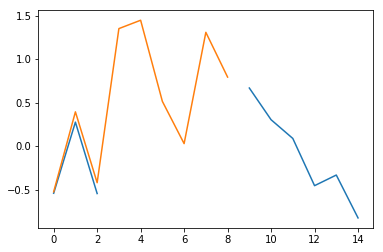

In [629]:
tr1=getTrials(TrCondMat,Good=True,Cues='L',Co=True)
tr2=getTrials(TrCondMat,Good=True,Cues='R',Co=True)
plt.plot(np.nanmean(zMat(X.loc[tr1],mu[cell],sig[cell]),0))
plt.plot(np.nanmean(zMat(X.loc[tr2],mu[cell],sig[cell]),0))

In [626]:
zMat(X.loc[tr2],mu[cell],sig[cell])

,Home,SegA,Center,SegB,I1,SegC,G1,SegD,G2,SegE,I2,SegF,G3,SegG,G4
6,-0.556915,0.646132,0.037231,NaN,NaN,NaN,NaN,NaN,NaN,2.018973,1.752890,0.912076,0.216722,NaN,NaN
8,-0.255866,1.350030,-1.049726,NaN,NaN,NaN,NaN,NaN,NaN,1.118501,1.145423,0.777460,0.169971,NaN,NaN
23,-0.537964,0.693034,-0.229803,NaN,NaN,NaN,NaN,NaN,NaN,0.649032,0.781353,0.550872,0.049707,NaN,NaN
33,-0.657386,0.564211,-0.398599,NaN,NaN,NaN,NaN,NaN,NaN,1.110116,0.793978,0.230573,-0.325172,NaN,NaN
52,-1.568479,0.398824,-0.625534,NaN,NaN,NaN,NaN,NaN,NaN,0.183642,0.323749,0.211626,-0.151412,NaN,NaN
66,-0.116939,-0.123634,-0.746514,NaN,NaN,NaN,NaN,NaN,NaN,1.190561,1.228063,0.655213,-0.139432,NaN,NaN
93,-0.485137,1.374595,-0.312024,NaN,NaN,NaN,NaN,NaN,NaN,1.147290,1.215215,0.788549,0.220654,NaN,NaN
99,-1.035061,0.073073,-0.037459,NaN,NaN,NaN,NaN,NaN,NaN,0.989605,1.066517,0.931095,0.774551,NaN,NaN
103,-0.389542,0.316605,-0.310391,NaN,NaN,NaN,NaN,NaN,NaN,0.335055,-0.097881,-0.477024,-0.682119,NaN,NaN
143,-0.757465,0.136678,-1.246876,NaN,NaN,NaN,NaN,NaN,NaN,0.226016,0.750847,0.490098,0.085773,NaN,NaN


In [380]:
TrSeqIDs = {}
OffTrSeqIDs = {}
for k in ValidTrSeqs.keys():
    TrSeqIDs[k] = []
    OffTrSeqIDs[k] = []
    
for k,v in TrSeqs.items():
    if len(v)>0:
        TrSeqIDs[v].append(k)

for k,v in OffTrSeqs.items():
    if len(v)>0:
        OffTrSeqIDs[v].append(k)
        
for k,v in TrSeqIDs.items():
    TrSeqIDs[k]=np.array(v)
for k,v in OffTrSeqIDs.items():
    OffTrSeqIDs[k]=np.array(v)

In [393]:
TrialInfo['Good']

KeyError: 'Good'

In [490]:
def getTrials(dat,**kwargs):
    nTr = dat.shape[0]
    trials = set(np.arange(nTr))
    try:
        for k,v in kwargs.items():
            trials = trials & set(np.where(dat[k]==v)[0])
    except:
        print('Invalid Selection {} {}'.format(k,v))
        pass
    return np.sort(np.array(list(trials)))
    
    

In [491]:
getTrials(TrCondMat,Good=True,Cues='R',Co=True),getTrials(TrCondMat,Good=True,Cues='R',Co=False)

(array([  0,   5,  17,  19,  22,  24,  25,  30,  31,  35,  37,  40,  42,
         47,  49,  53,  56,  57,  59,  60,  62,  64,  65,  70,  71,  72,
         78,  80,  81,  85,  86,  87,  91,  94,  97, 106, 107, 108, 110,
        125, 128, 129, 136, 142, 144, 149, 151, 153, 154, 155, 161, 162,
        164, 169, 170, 173, 176, 180, 184, 186, 187, 190, 191, 193, 195,
        196, 198, 202, 204, 206]),
 array([  6,   8,  23,  33,  52,  66,  93,  99, 103, 143, 150, 166, 177,
        192]))

In [495]:
TrCondMat.iloc[getTrials(TrCondMat,Good=True,Cues='R',Short)]['Traj'],TrCondMat.iloc[getTrials(TrCondMat,Good=True,Cues='L')]['Traj']

(0      R_S1
 5      R_S2
 6      L_S3
 8      L_S3
 17     R_S2
 19     R_S2
 22     R_S2
 23     L_S3
 24     R_S2
 25     R_S2
 30     R_L1
 31     R_S2
 33     L_S3
 35     R_L1
 37     R_L1
 40     R_L1
 42     R_S2
 47     R_L1
 49     R_S2
 52     L_S3
 53     R_S2
 56     R_L1
 57     R_L1
 59     R_L1
 60     R_S2
 62     R_S2
 64     R_S2
 65     R_S2
 66     L_S3
 70     R_S2
        ... 
 144    R_S2
 149    R_S2
 150    L_S3
 151    R_L1
 153    R_S2
 154    R_L1
 155    R_S2
 161    R_L1
 162    R_S2
 164    R_S2
 166    L_S3
 169    R_S2
 170    R_L1
 173    R_S2
 176    R_L1
 177    L_S3
 180    R_S2
 184    R_S2
 186    R_L1
 187    R_S2
 190    R_S2
 191    R_S2
 192    L_S3
 193    R_S2
 195    R_L1
 196    R_S2
 198    R_S2
 202    R_L1
 204    R_S2
 206    R_L1
 Name: Traj, Length: 84, dtype: object, 2      R_L1
 3      L_L4
 4      R_L1
 7      R_L1
 9      L_L4
 10     L_L4
 11     R_S2
 12     L_L4
 13     L_L4
 14     L_L4
 16     L_L4
 18     L_L4
 20     L_S3

In [438]:
TrCondMat['Traj'][0][2]

'S'

In [224]:
ZoneN = {}
for n,z in TMF.Zones.items():
    ZoneN[z]=n

ValidTrSeqN = {}
for k,v in ValidTrSeqs.items():
    ValidTrSeqN[k] = [ZoneN[z] for z in ValidTrSeqs[k]]

In [259]:
print(list(TrialInfo['ValidSeqTrID'].values())[:10])
print(list(TrialInfo['ValidSeqOffTrID'].values())[:10])

['R_S1', [], 'R_L1', 'L_L4', 'R_L1', 'R_S2', 'L_S3', 'R_L1', 'L_S3', 'L_L4']
['R_L1', [], 'R_S1', 'L_S4', [], 'R_S2', [], [], [], 'L_S4']


In [246]:
D = pd.DataFrame()
Dout = {}
Din = {}
for k in ValidTrSeqs.keys():
    nPos = len(ValidTrSeqs[k])
    nSeqTr = len(TrSeqIDs[k])
    
    if nSeqTr>0:
        mat = np.zeros((nSeqTr,nPos))
        cTr = np.zeros(nSeqTr)
            
        cnt =0
        for i in TrSeqIDs[k]:
            cTr[cnt] = i in TrialInfo['All']['Co']
            mat[cnt]= TrZnFR[i]
            cnt+=1

        d = pd.DataFrame(mat,columns=ValidTrSeqs[k])
        d = d.melt(var_name='Pos',value_name = 'FR') 
        d = d.assign(io = ['out']*(nSeqTr*nPos))
        d = d.assign(corr = np.tile(cTr,nPos))
        d = d.assign(PosN = np.repeat(ValidTrSeqN[k],nSeqTr))
        d = d.assign(trialID = np.tile(TrSeqIDs[k], nPos).astype(int))
        d = d.assign(traj = [k]*(nSeqTr*nPos))
        D = pd.concat([D,d])
        
    Dout[k]=mat
    nSeqTr = len(OffTrSeqIDs[k])
    if nSeqTr>0:
        mat = np.zeros((nSeqTr,nPos))
        cTr = np.zeros(nSeqTr)
        cnt =0
        for i in OffTrSeqIDs[k]:
            cTr[cnt] = i in TrialInfo['All']['Co']
            mat[cnt]= OffTrZnFR[i]
            cnt+=1

        d2 = pd.DataFrame(mat,columns=ValidTrSeqs[k])
        d2 = d2.melt(var_name='Pos',value_name = 'FR')
        d2 = d2.assign(io = ['in']*(nSeqTr*nPos))
        d2 = d2.assign(corr = np.tile(cTr,nPos))
        d2 = d2.assign(PosN = np.repeat(ValidTrSeqN[k][::-1],nSeqTr))
        d2 = d2.assign(trialID = np.tile(OffTrSeqIDs[k], nPos).astype(int))
        d2 = d2.assign(traj = [k]*(nSeqTr*nPos))

        D = pd.concat([D,d2])
    
    Din[k]=mat
#     f,ax=plt.subplots(1, figsize=(8,5))
#     sns.violinplot(x='Pos',y='FR',hue='io',data=d3,cut=0,inner=None,ax=ax)
#     sns.swarmplot(x='Pos',y='FR',hue='io',data=d3,dodge=True,size=3,color='w',ax=ax)

#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[:2], labels[:2])
#     plt.grid()
    #f.savefig(('/mnt/c/Users/alexg8/Desktop/io_traj_{}_cell_{}.pdf').format(k,cell),dpi=500, bbox_inches='tight',pad_inches=0.2)
    #plt.close(f)

In [285]:
DoutM = {}
for k in Dout.keys():
    DoutM[k] = zMat(Dout[k],mu[cell],sig[cell])


In [382]:
TrialInfo['Cues']=='R'

array([ True,  True, False, False, False,  True,  True, False,  True,
       False, False, False, False, False, False,  True, False,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
       False, False, False,  True,  True, False,  True, False,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False, False,  True, False,  True, False, False,  True,  True,
       False, False,  True,  True, False,  True,  True, False,  True,
       False,  True,  True,  True, False,  True, False,  True,  True,
        True, False, False,  True, False, False,  True, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True, False,  True,  True, False, False,  True, False,
        True, False, False, False,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False,

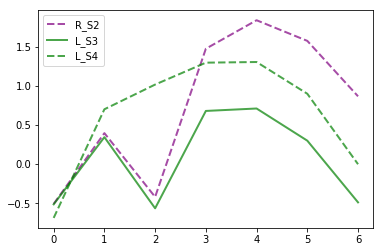

In [372]:
for k in Dout.keys():
    trials = TrSeqIDs[k]
    cues = TrialInfo['Cues'][trials]
    if k[2]=='S' and len(Dout[k])>5:
        if k[0]=='L':
            col = 'g'
        else:
            col = 'purple'

        if k[3] in ['1','3']:
            st = '-'
        else:
            st = '--'
        plt.plot(DoutM[k],label=k, alpha=0.7, linewidth=2, color=col,linestyle=st)
plt.legend()

In [378]:
TrialInfo['Cues'][TrSeqIDs[k]]

array(['L', 'L', 'L', 'L', 'L', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'L',
       'R', 'R', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'R', 'L', 'L', 'L',
       'L', 'R', 'R', 'R', 'L', 'R', 'L', 'R', 'L', 'L', 'L', 'R', 'L',
       'R', 'R', 'R', 'L'], dtype='<U1')

'L'

In [287]:
def zMat(mat,mu,sig):
    return np.mean((mat-mu)/sig,0)

In [281]:

sig

array([ 0.68423244,  1.16399611,  4.0475013 ,  6.6048773 ,  8.26262397,
        7.53833364,  5.40259314,  9.02478519,  7.89578605,  6.53334697,
        9.26563681,  8.80866298,  1.44360144,  6.51492947, 17.10743783,
       15.05154849])

In [233]:
D[(D['Pos']=='SegA') & (D['corr']==1)].mean(),D[(D['Pos']=='SegA') & (D['corr']==0)].mean() 

(FR          37.850144
 corr         1.000000
 PosN         4.774086
 trialID    108.475083
 dtype: float64, FR         37.406553
 corr        0.000000
 PosN        3.821429
 trialID    99.000000
 dtype: float64)

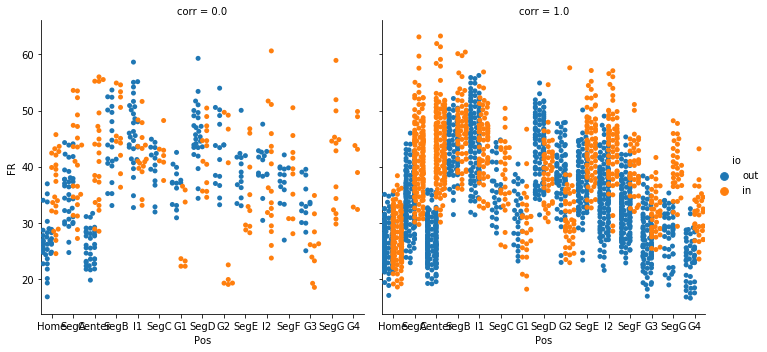

In [207]:
#sns.violinplot(x='Pos',y='FR',hue='io',,data=d3,cut=0,inner=None,ax=ax)
#f,ax=plt.subplots(1, figsize=(10,5))

# g = sns.FacetGrid(D,col='io',hue='corr',height=6)
# g.map(sns.violinplot,'Pos','FR',cut=0)
g = sns.catplot(x='Pos',y='FR',hue='io',col='corr',data=D,kind='swarm',dodge=True)

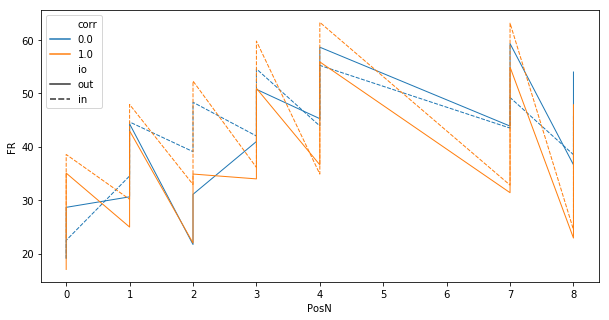

In [243]:
f,ax=plt.subplots(1, figsize=(10,5))
sns.lineplot(x='PosN',y='FR',hue='corr',style='io',data=D[D['traj']=='R_S2'],estimator=None,lw=1)

In [245]:
D[D['traj']=='R_S2']

,Pos,FR,io,corr,PosN,trialID,traj
0,Home,25.245368,out,1.0,0,6,R_S2
1,Home,28.666618,out,0.0,0,12,R_S2
2,Home,23.893784,out,1.0,0,18,R_S2
3,Home,28.671975,out,1.0,0,20,R_S2
4,Home,23.450069,out,1.0,0,23,R_S2
5,Home,27.426531,out,1.0,0,25,R_S2
6,Home,31.102937,out,1.0,0,26,R_S2
7,Home,31.118689,out,1.0,0,32,R_S2
8,Home,26.679535,out,0.0,0,33,R_S2
9,Home,27.603303,out,1.0,0,43,R_S2


In [161]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("FR ~ corr+Pos*io+traj", data=D,groups=D["trialID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,D['FR'])**2)[0,1]))

               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     FR        
No. Observations:     2879        Method:                 REML      
No. Groups:           200         Scale:                  24.3439   
Min. group size:      7           Likelihood:             -8756.1639
Max. group size:      22          Converged:              Yes       
Mean group size:      14.4                                          
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              39.743    0.836  47.521 0.000  38.103  41.382
Pos[T.G1]             -16.371    0.965 -16.960 0.000 -18.263 -14.479
Pos[T.G2]             -14.295    0.821 -17.405 0.000 -15.905 -12.685
Pos[T.G3]             -11.163    0.819 -13.632 0.000 -12.768  -9.558
Pos[T.G4]              -9.018    0.935  -9.643 0.0

In [140]:
md = smf.mixedlm("FR ~ 0+Pos+io+traj", data=D,groups=D["trialID"])
mdf = md.fit()
print(mdf.summary())
print("R2 = {0:.3f}".format((np.corrcoef(mdf.fittedvalues,D['FR'])**2)[0,1]))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: FR        
No. Observations: 2879    Method:             REML      
No. Groups:       200     Scale:              34.6738   
Min. group size:  7       Likelihood:         -9250.5466
Max. group size:  22      Converged:          Yes       
Mean group size:  14.4                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Pos[Center]  33.896    0.839  40.396 0.000 32.251 35.540
Pos[G1]      29.274    1.093  26.789 0.000 27.132 31.416
Pos[G2]      34.662    0.985  35.188 0.000 32.731 36.592
Pos[G3]      30.800    0.895  34.417 0.000 29.046 32.554
Pos[G4]      28.839    0.984  29.312 0.000 26.911 30.768
Pos[Home]    26.775    0.839  31.910 0.000 25.130 28.420
Pos[I1]      42.743    0.934  45.752 0.000 40.912 44.574
Pos[I2]      39.866    0.837  47.617 0.00

In [154]:
mdf.t_test_pairwise("Pos")

ValueError: r_matrix for t-test should have 23 columns

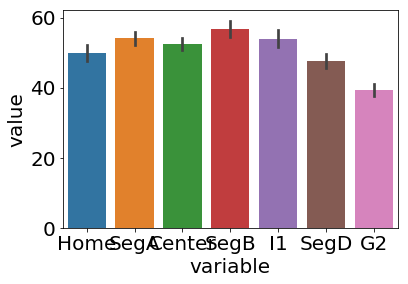

In [260]:
k ='R_S2' 
nPos = len(ValidTrSeqs[k])
nSeqTr = len(Y[k])
mat = np.zeros((nSeqTr,nPos))

cnt =0
for i in Y[k]:
    mat[cnt]= X[i]
    cnt+=1
    
d = pd.DataFrame(mat,columns=ValidTrSeqs[k])
sns.barplot(x='variable',y='value',data=d.melt())

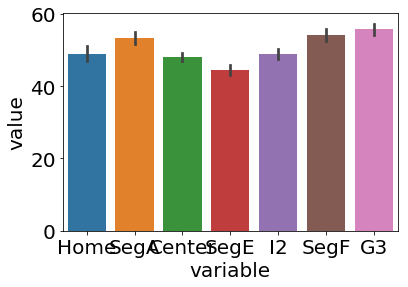

In [199]:
a=list(TrSeqs.values())
vTr = np.array(vTr)
apd = pd.Series(a)
apd.iloc[vTr-1].value_counts()
#apd.iloc[vTr]
#pd.Series(a).value_counts().plot('bar')

L_S3    61
R_S2    48
L_L4    43
R_L1    37
R_S1     5
L_L3     1
dtype: int64

In [257]:
Y

{'R_S1': [1, 52, 168, 180, 210],
 'R_S2': [6,
  12,
  18,
  20,
  23,
  25,
  26,
  32,
  33,
  43,
  50,
  54,
  61,
  63,
  65,
  66,
  71,
  73,
  79,
  81,
  87,
  93,
  99,
  107,
  108,
  109,
  111,
  129,
  132,
  143,
  145,
  150,
  154,
  156,
  163,
  165,
  166,
  170,
  174,
  181,
  185,
  188,
  191,
  192,
  194,
  197,
  199,
  205],
 'L_S3': [7,
  9,
  21,
  24,
  27,
  29,
  30,
  34,
  35,
  40,
  42,
  46,
  47,
  51,
  53,
  67,
  70,
  77,
  78,
  83,
  84,
  85,
  89,
  90,
  94,
  96,
  97,
  100,
  104,
  106,
  110,
  112,
  114,
  116,
  117,
  123,
  124,
  127,
  131,
  133,
  134,
  144,
  146,
  147,
  148,
  149,
  151,
  167,
  169,
  176,
  178,
  183,
  184,
  186,
  189,
  193,
  200,
  201,
  202,
  204,
  209],
 'L_S4': [],
 'R_L1': [3,
  5,
  8,
  22,
  31,
  36,
  38,
  41,
  44,
  48,
  57,
  58,
  60,
  72,
  82,
  86,
  88,
  92,
  95,
  98,
  101,
  115,
  126,
  130,
  137,
  152,
  155,
  161,
  162,
  171,
  172,
  177,
  187,
  195,
  1